In [1]:
import pandas as pd
import numpy as np
import matplotlib
import string
import re
import seaborn as sns
from difflib import *
import math
import time
import random
import pickle

# Data Structure and Help Functions

Product Name dictionary: Each product name, extract tokens from it and generate token combinations.

![product_dict](./notebook_image/product_dict.png)

In [2]:
# Class product
class Product:
    def __init__(self, name):
        self.name = name
        self.token = set()   # store the id of all token in the product name
        self.combination = {}  # store the signature of all the combinations of the product name as key, and store the score 

Token Lexicon: This is an ordinary lexicon structure $L_w$ that is used to accommodate
the tokens extracted from the titles of the products. For each token w, the token
lexicon also stores:
- a unique integer identifier (token ID),
- a frequency value $f_w$ that represents the number of products that contain w in their titles, and
- a special variable $s_w$ that is set equal to the semantics of w

![product_dict](./notebook_image/token_lexicon.png)

In [3]:
# Class token lexicon
class TokenLexicon:
    def __init__(self):
        self.tokentoidx = {}
        self.idxtotoken = {}
        self.idxtofrequency = {}
        self.idxtofield = {}
        self.count = 0
    
    def insert(self, name):
        product = Product(name)
        tokens = name.split()
        for t in tokens:
            if t in self.tokentoidx:
                self.idxtofrequency[self.tokentoidx[t]] += 1
                product.token.add(self.tokentoidx[t])
                continue
            else:
                self.tokentoidx[t] = self.count
                self.idxtotoken[self.count] = t
                self.idxtofrequency[self.count] = 1
                if t[0].isdigit() == True or t in size_tokens:
                    self.idxtofield[self.count] = 'size'
                elif t in generic_names:
                    self.idxtofield[self.count] = 'class'
                else:
                    self.idxtofield[self.count] = 'normal'
                product.token.add(self.count)
                self.count += 1
        return product

Eventually, each combination record is associated with the following attributes:
- its signature $g_c$,
- a frequency value $f_c$ that stores the number of the titles that contain c, and
- a distance accumulator ${d_c}^{acc}$ that maintains the sum of the distances of c from the beginning of the titles.
- length of the combination $k_c$

Use dict() to store, as {signature: [$f_c$,${d_c}^{acc}$,$k_c$]}

![product_dict](./notebook_image/combination_lexicon.png)

In [4]:
# Class combination lexicon
class CombinationLexicon:
    def __init__(self):
        self.lexicon = {}    #combination signature: [frequency, distance, length]
        self.totalfrequency = 0
        self.totallength = 0
        self.avglength = 0
    
    def insert(self, combination, tokenlexicon, title):
        signature = self._combinationSignature(combination, tokenlexicon)
        distance = self._combinationDistance(combination, title)
        product_dict[title].combination[signature] = None # set score of this combination as None
        self.totalfrequency += 1
        self.totallength += len(combination)
        self.avglength = self.totallength / self.totalfrequency
        if signature in self.lexicon:
            self.lexicon[signature][0] += 1
            self.lexicon[signature][1] += distance
        else:
            self.lexicon[signature] = [1, distance, len(combination)]
    
    # help function
    def _combinationSignature(self, combination, tokenlexicon):
        idx = [tokenlexicon.tokentoidx[token] for token in combination]
        idx.sort()
        idx = [str(x) for x in idx]
        return '_'.join(idx)

    def _combinationDistance(self, combination, title):
        d = 0
        for i, token in enumerate(combination):
            d += (i-title.index(token))**2
        return np.sqrt(d)

In [5]:
# help function for generate combination
def combinationGenerate(arr, n, r): 
    data = [0]*r;    
    res = []
    combinationUtil(arr, data, res, 0, n - 1, 0, r)
    return res

def combinationUtil(arr, data, res, start, end, index, r): 
    temp = []
    if index == r: 
        for j in range(r): 
            temp.append(data[j])
        res.append(temp)
        return
    i = start
    while i <= end and end - i + 1 >= r - index: 
        data[index] = arr[i]; 
        combinationUtil(arr, data, res, i + 1, end, index + 1, r); 
        i += 1

In [6]:
# product name clean
def split_unit(s):
    # 'crv6pk' to 'crv 6pk'
    for i, val in enumerate(s):
        if val.isdigit() == True:
            return s[:i]+' '+s[i:]

def clean_name(name):
    name = str(name)
    name = name.lower()
    name = name + ' '
    name = name.replace('ounce', 'oz')
    name = name.replace('fluid', 'fl')
    name = name.replace('pack', 'pk')
    name = name.replace('count', 'ct')
    name = name.replace('inch', 'in')
    name = name.replace('gallon', 'gal')
    if ' w/' in name or 'w/ ' in name:
        name = name.replace('w/', '')
    temp = re.findall(r'[0-9]*[\.]*[0-9]+\/[0-9]*[\.]*[0-9]+|[0-9]*[\.]*[0-9]+\%|[0-9]*\.[0-9]+|[0-9]+|\w+|\s+', name)
    for i in range(len(temp)):  # '.75oz to 0.75oz'
        part = temp[i]
        if part[0] == '.' and part[1].isdigit():
            temp[i] = '0'+part
    name = ''.join(temp)
    units = ['lb', 'oz', 'fl', 'ct', 'pk', 'pc', 'gal', 'l', 'ml', 'kg', 'day', 'days', 'in', 'item']
    for u in units:
        if ' '+u+' ' in name:
            name = name.replace(' '+u+' ', u+' ')
    temp = re.findall(r'[a-z]+[0-9]*[\.]*[0-9]+[a-z]+|[a-z]+[0-9]+[\.]*[0-9]+\%', name) # example find 'crv6pk' and split them
    for part in temp:
        name = name.replace(part, split_unit(part))
    name = ' '.join(name.split())
    return name

# Tag Tokens Processing

In [7]:
tag = pd.read_csv("../raw_data/third_party/generic_food.csv")
tag.head()

,FOOD NAME,SCIENTIFIC NAME,GROUP,SUB GROUP
0,Angelica,Angelica keiskei,Herbs and Spices,Herbs
1,Savoy cabbage,Brassica oleracea var. sabauda,Vegetables,Cabbages
2,Silver linden,Tilia argentea,Herbs and Spices,Herbs
3,Kiwi,Actinidia chinensis,Fruits,Tropical fruits
4,Allium (Onion),Allium,Vegetables,Onion-family vegetables


In [8]:
def generic_name_extract(name):
    name = name.split()
    if len(name) > 2:
        return ''
    elif len(name) == 2:
        if name[1][0].isalpha() == True:
            name = name[1]
        else:
            name = name[0]
    else:
        name = name[0]
    name = name.lower()
    name = re.sub('['+string.punctuation+']+','',name)
    return name

In [9]:
generic_names = set()
for name in tag['FOOD NAME']:
    name = generic_name_extract(name)
    if name != '':
        generic_names.add(name)

# Size Tokens

In [10]:
size_tokens = {'large', 'extra', 'small', 'mini', 'single', 'double', 'size', 'family', 'dozen', 'one', 'two'}
size_tokens

{'double',
 'dozen',
 'extra',
 'family',
 'large',
 'mini',
 'one',
 'single',
 'size',
 'small',
 'two'}

# Data Processing

In [11]:
# USDA data
df = pd.read_csv("../raw_data/third_party/food.csv", dtype=str) # USDA dataset

In [12]:
df = df[['description']]
df.drop_duplicates(inplace=True)

In [13]:
df['label_name'] = df['description'].apply(clean_name)
df = df[['label_name']]
df.drop_duplicates(inplace=True)

In [14]:
df.shape

(238066, 1)

# Generate Token Lexicon

In [15]:
tokenlexicon = TokenLexicon()

In [16]:
product_dict = {} # Forward Index R in the paper
for title in df['label_name']:
    product = tokenlexicon.insert(title)
    product_dict[title] = product

In [17]:
print('number of tokens:', tokenlexicon.count)

number of tokens: 39441


In [18]:
print('length check tokentoidx: ', len(tokenlexicon.tokentoidx))
print('length check idxtotoken: ', len(tokenlexicon.idxtotoken))
print('length check idxtofrequency: ', len(tokenlexicon.idxtofrequency))

length check tokentoidx:  39441
length check idxtotoken:  39441
length check idxtofrequency:  39441


In [19]:
len(product_dict)

238066

# Generate Combination Lexicon

In [20]:
combinationlexicon = CombinationLexicon()

In [21]:
max_length = 5
for title in df['label_name']:
    tokens = title.split()
    all_combinations = []
    l = len(tokens)
    for k in range(2, min(l, max_length)+1):
        all_combinations += combinationGenerate(tokens, len(tokens), k)
    for combination in all_combinations:
        combinationlexicon.insert(combination, tokenlexicon, title)

In [22]:
print('average length of combinations: ', combinationlexicon.avglength)

average length of combinations:  4.48913921839268


In [23]:
print('total number of combinations: ', len(combinationlexicon.lexicon))

total number of combinations:  42896200


In [24]:
output = open('combo_lexicon.pkl', 'wb')
pickle.dump(combinationlexicon.lexicon, output)

In [25]:
output = open('tokentoidx.pkl', 'wb')
pickle.dump(tokenlexicon.tokentoidx, output)

In [26]:
output = open('idxtotoken.pkl', 'wb')
pickle.dump(tokenlexicon.idxtotoken, output)

In [27]:
output = open('idxtofrequency.pkl', 'wb')
pickle.dump(tokenlexicon.idxtofrequency, output)

In [28]:
output = open('idxtofield.pkl', 'wb')
pickle.dump(tokenlexicon.idxtofield, output)

# Combination scoring

For each product name, the combination with highest score is used as the generic name tag for this product name. Product names with the same tag are clustered into the same group.

Combination scoring function:

![product_dict](./notebook_image/scoring_function.png)

In [29]:
def combinationGrading(signature, P, S, C, N, a=0.001, b=0.5):
    # signature: signature of the combination
    # P: total number of product name
    # U: total number of 'size' tokens
    # C: total number of 'class' tokens
    # N: total number of 'normal' tokens
    f, d, k = combinationlexicon.lexicon[signature]
    idx = signature.split('_')
    yc = 0
    for n in idx:
        n = int(n)
        if tokenlexicon.idxtofield[n] == 'size':
            yc += np.log(P/tokenlexicon.idxtofrequency[n]) * (1/S) / (1-b+b*k/combinationlexicon.avglength)
        elif tokenlexicon.idxtofield[n] == 'class':
            yc += np.log(P/tokenlexicon.idxtofrequency[n]) * (1/C) / (1-b+b*k/combinationlexicon.avglength)
        else:
            yc += np.log(P/tokenlexicon.idxtofrequency[n]) * (1/N) / (1-b+b*k/combinationlexicon.avglength)
    score = k*(yc**2)/(a+d)*np.log(f)
    return score

In [30]:
combination_scores = {}
P = df.shape[0]
S = 0
C = 0
N = 0
for field in tokenlexicon.idxtofield.values():
    if field == 'size':
        S += 1
    elif field == 'class':
        C += 1
    else:
        N += 1
print('S: ', S)
print('C: ', C)
print('N: ', N)

S:  11805
C:  518
N:  27118


In [31]:
for signature in combinationlexicon.lexicon:
    combination_scores[signature] = combinationGrading(signature, P, S=27000, C=500, N=11000)

# Find highest-score combination for each title 

In [32]:
cluster = {}
for name in product_dict:
    score = -1
    res = ''
    p = product_dict[name]
    for c in p.combination:
        p.combination[c] = combination_scores[c]
        if combination_scores[c] > score:
            score = combination_scores[c]
            res = c
    if res != '':
        idx = res.split('_')
        idx = [int(n) for n in idx]
        generic = ' '.join([tokenlexicon.idxtotoken[n] for n in idx])
        if generic in cluster:
            cluster[generic].append(name)
        else:
            cluster[generic] = [name]

In [33]:
cluster

{'tutturosso green 14.5oz nsa': ['tutturosso green 14.5oz nsa italian diced tomatoes',
  'tutturosso green 14.5oz nsa diced tomatoes'],
 'tutturosso green 14.5oz italian': ['tutturosso green 14.5oz italian diced tomatoes',
  'tutturosso green 14.5oz italian stewed tomatoes'],
 'honeysuckle white white turkey': ['honeysuckle white fresh 97% ground white turkey',
  'honeysuckle white 97% ground white turkey'],
 'honeysuckle ground turkey 85%': ['honeysuckle whtie 85% ground turkey',
  'honeysuckle white 85% ground turkey',
  'honeysuckle white fresh ground turkey 85%'],
 'kelloggs poptarts cherry': ['kelloggs poptarts wild cherry 14.1oz'],
 'kelloggs poptarts strawberry 14.7oz': ['kelloggs poptarts frosted strawberry 14.7oz',
  'kelloggs poptarts strawberry 14.7oz'],
 'poptarts frosted strawberry kellogg': ['kellogg poptarts frosted strawberry 22oz',
  'kellogg poptarts frosted strawberry slurpee 3.67oz'],
 'sunshine cheezit crackers 3oz': ['sunshine cheezit crackers original 3oz'],
 'su

In [34]:
len(cluster)

157083

In [35]:
cluster_output = open('cluster_output_usda.pkl', 'wb')
pickle.dump(cluster, cluster_output)

### Examples of what products are clustered into the same group
 - different sizes
 - different flavor

In [36]:
i= 0
for p in cluster:
    if len(cluster[p]) >= 3:
        i+= 1
        print(p, ': ', cluster[p], '\n')
print(i)

honeysuckle ground turkey 85% :  ['honeysuckle whtie 85% ground turkey', 'honeysuckle white 85% ground turkey', 'honeysuckle white fresh ground turkey 85%'] 

sunshine cheezit crackers hot spicy :  ['sunshine cheezit crackers hot spicy 7oz', 'sunshine cheezit crackers hot spicy 12.4oz', 'sunshine cheezit crackers hot spicy 1.65oz', 'sunshine cheezit crackers hot spicy 3oz', 'sunshine cheezit crackers hot spicy 9oz', 'sunshine cheezit crackers hot spicy 3.25oz'] 

keebler oatmeal cookies :  ['keebler oatmeal cookies ctry style 10.1oz', 'keebler oatmeal cookies iced 13.7oz', 'keebler oatmeal cookies original 13.7oz'] 

kelloggs poptarts beer :  ['kelloggs poptarts root beer 3.53oz', 'kelloggs poptarts root beer 28.2oz', 'kelloggs poptarts root beer 14.1oz'] 

sunshine cheezit crackers whole grain :  ['sunshine cheezit crackers whole grain 1oz', 'sunshine cheezit crackers whole grain 12.4oz', 'sunshine cheezit crackers whole grain 48oz 4ct'] 

sunshine cheezit crackers snack mix :  ['suns

turkey pie pot :  ['banquet turkey pot pie 7oz', 'meal mart turkey pot pie', 'turkey pot pie', 'roasted turkey pot pie', 'chicken or turkey pot pie', 'turkey pot pie frozen entree'] 

pancakes sausage odoms tennessee pride :  ['odoms tennessee pride sausage maple pancakes 10ct 13.7oz', 'odoms tennessee pride sausage pancakes 13.7oz', 'odoms tennessee pride sausage maple pancakes 10ct'] 

beef hebrew national franks :  ['hebrew national 97% fat free beef franks 11oz 11oz', 'hebrew national beef franks 36oz', 'hebrew national beef franks 16oz', 'hebrew national kosher beef franks 5lb'] 

slim jim pepperoni :  ['slim jim pepperoni giant stick 0.97oz', 'slim jim pepperoni bites 4oz', 'slim jim pepperoni sticks 4.2oz'] 

slim jim monster :  ['slim jim monster smoked meat stick tabasco flavor 1.94oz 1.94oz', 'slim jim monster original stick 1.94oz', 'slim jim monster original meat stick 1.94oz'] 

slim jim gable :  ['slim jim gable top jalapeno 3.92oz', 'slim jim gable top pepperoni 3.92oz',

cinnamon crunch toast :  ['cinnamon toast crunch cerealonthego pouch', 'pillsbury cinnamon toast crunch toaster strudel pastries 12ct', 'cinnamon toast crunch soft baked treats'] 

chip cookie choc :  ['annies hmgrwn org cookie bites choc chip', 'colossal choc chip cookie', 'gourmet white dark choc chip cookie'] 

soup meatball :  ['progresso light italian style meatball soup', 'annies organic meatball soup with pasta vegetables', 'albondigas meatball soup', 'meatball soup home recipe mexican style'] 

sauce pasta table good frzr :  ['the good table frzr to plate pasta sauce marsala', 'the good table frzr to plate pasta sauce lemon grlc herb', 'the good table frzr to plate pasta sauce teriyaki'] 

pasta pasta salad :  ['bty crk suddenly pasta salad pasta seas caesar twinpk', 'hidden valley pasta salad penne pasta seasoning mix bacon cheddar naturally flavored', 'classic pasta vegetable blend seasoning mix pasta salad'] 

hot enchilada :  ['old el paso hot red enchilada sauce', 'hot gre


blue mussels :  ['25/30ct wh blue mussels', 'whole blue mussels', 'organic blue mussels'] 

portions cobia :  ['8/10oz cobia portions', '7/9oz cobia portions', '6/8oz co cobia portions'] 

grape water beverage propel :  ['propel zero calories grape flavored water beverage 616.9 floz 101.4 floz 6pk plastic bottles', 'propel grape water beverage 16.9 floz plastic bottle', 'propel grape water beverage 24 floz plastic bottle', 'propel workout water beverage with vitamins grape'] 

mix tortilla flour harina preparada :  ['quaker harina preparada white flour tortilla mix 4 pound paper bag', 'quaker harina preparada white flour tortilla mix 8 pound paper bag', 'quaker harina preparada white flour tortilla mix 20 pound paper bag'] 

corn yellow cut :  ['32.00oz tostitos thick cut yellow corn', 'yellow cut corn', 'cut yellow corn'] 

peach nectar :  ['looza nectar peach 33.81z', 'clear american peach nectar', 'peach nectar', 'sunchy lite peach nectar', 'organic peach nectar', 'white peach nect

cookies milk choc farm pepperidge :  ['pepperidge farm cookies double milk choc', 'pepperidge farm cookies milk choc', 'pepperidge farm cookies soft baked milk choc chunk'] 

pastry farm pepperidge :  ['pepperidge farm pastry apple', 'pepperidge farm pastry shells', 'pepperidge farm pastry raspberry', 'pepperidge farm pastry sheets'] 

soup noodle chunky campbells :  ['campbells chunky soup chicken noodle bacon', 'campbells chunky soup chicken noodle', 'campbells chunky classic chicken noodle soup'] 

mix cake molten lava :  ['godiva molten lava cake mix', 'molten lava cake mix', 'chocolate molten lava cake mix'] 

tomato soup rice :  ['campbells soup tomato rice', 'tabatchnick balsamic tomato rice soup', 'cajun tomato rice soup with spiced pepitas'] 

cream soup shrimp :  ['campbells soup cream shrimp', 'shrimp soup cream of ns as to prepared with milk or water', 'shrimp soup cream of prepared with milk', 'shrimp soup cream of prepared with water', 'soup cream of shrimp canned condens

mix seasoning mrs dash :  ['mrs dash pot roast seasoning mix', 'mrs dash sloppy joe seasoning mix', 'mrs dash taco seasoning mix', 'mrs dash fajita seasoning mix'] 

cheese dinner macaroni :  ['macaroni cheese dinner', 'cheese cause macaroni dinner', 'nondairy macaroni cheese dinner'] 

ground bison :  ['premium ground bison', 'ground bison', 'markets of meijer ground bison'] 

butter beans :  ['butter beans', 'grace classic butter beans', 'premium butter beans'] 

beans garbanzo :  ['garbanzo beans', 'isola garbanzo beans', 'emilios garbanzo beans'] 

frosted whole cereal oat :  ['frosted whole grain oat cereal with lunar marshmallows', 'frosted whole grain oat cereal with marshmallows', 'frosted whole grain oat cereal'] 

coconut banana milk :  ['sprout coconut milk smoothie smash peach banana', 'tag brand banana and tapioca pearlin coconut milk', 'banana chiain coconut milk'] 

cream peanut butter cup light :  ['weis light ice cream chocolate peanut butter cup', 'peanut butter cup l

peanuts boiled :  ['boiled peanuts', 'southern bbq boiled peanuts', 'peanuts boiled'] 

ginger candy :  ['gin gins ginger caramel candy', 'ginger candy', 'crystallized ginger candy', 'ice chips candy real ginger', 'ginger orange candy'] 

wheat bulkie :  ['harvest pride soft wheat bulkie rolls', 'wheat bulkie rolls', 'organic wheat bulkie rolls'] 

bread 4c :  ['4c plain bread crumbs', '4c bread crumbs plain', '4c seasoned bread crumbs', '4c bread crumbs seasoned salt free', '4c bread crumbs seasoned'] 

pumpkin pie :  ['pumpkin pie', 'gmh pumpkin pie', 'pie pumpkin'] 

apple pie :  ['apple pie', 'amys apple pie', 'apple pie fruitilicious', 'pie apple diet'] 

chocolate pie eclair :  ['chocolate eclair pie', 'old fashioned eclair pie baked chocolate', 'old fashioned chocolate eclair pie'] 

frosted cinnamon sugar toaster :  ['frosted brown sugar cinnamon toaster pastries', 'brown sugar cinnamon frosted toaster pastries', 'toaster pastries frosted brown sugar cinnamon', 'frosted toaster

tortilla triangles :  ['tortilla triangles', 'pueblo lindo tortilla triangles', 'yellow corn tortilla triangles'] 

salt vinegar popped :  ['weis quality popped chips salt vinegar', 'live love snack popped multigrain supersnack sea salt vinegar', 'sea salt malt vinegar popped chips'] 

sauce francese :  ['victoria simmer francese sauce', 'francese gourmet cooking sauce', 'weis francese sauce'] 

artichoke marinated salad :  ['victoria marinated artichoke salad', 'roland marinated artichoke salad with olives pimientos', 'marinated artichoke salad'] 

hot dog :  ['victoria hot dog onions', 'hot dog', 'world famous hot dog slaw', 'las vegas hot dog', 'cincinnatis hot dog'] 

olive oil vinegar victoria :  ['victoria sliced marinated mushroomsin olive oil vinegar marinade', 'victoria antipasto peppers with olive oil vinegar', 'victoria marinated mushrooms with olive oil and vinegar marinade'] 

mushroom salad :  ['victoria mushroom salad', 'balsamic mushroom grains salad shacker', 'mushroom

butter butter garlic garlic croutons :  ['mrs cubbisons butter garlic croutons butter garlic', 'garlic butter seasoned croutons garlic butter', 'butter garlic croutons butter garlic'] 

mix dip roundys :  ['roundys ranch dip mix', 'roundys salsa dip mix', 'roundys guacamole dip mix'] 

stuffed minced olives pimiento manzanilla :  ['stuffed manzanilla olives with minced pimiento', 'manzanilla olives with minced pimiento stuffed', 'manzanilla olives stuffed with minced pimiento', 'manzanilla minced pimiento stuffed olives', 'minced pimiento stuffed manzanilla olives'] 

stuffed minced olives queen pimiento :  ['stuffed queen olives with minced pimiento', 'queen olives stuffed with minced pimiento', 'jumbo queen olives stuffed with minced pimiento'] 

black olives pitted ripe :  ['ripe pitted black olives', 'pitted ripe black olives', 'black pitted ripe olives', 'black ripe pitted olives'] 

dill milwaukees wisconsins :  ['milwaukees wisconsins baby dill pickles', 'milwaukees wisconsins p

buttermilk key food :  ['key food mini pancakes buttermilk', 'key food buttermilk waffles', 'key food pancakes buttermilk'] 

key cut food :  ['key food cut corn fresh frozen vegetables', 'key food crinkle cut carrots', 'key food cut broccoli'] 

tamarind tamarindo :  ['la fe tamarindo tamarind pulp', 'klass tamarindo tamarind flavored drink mix', 'mi tamarindo tamarind drink', 'tamarindo tamarind beverage concentrate tamarindo'] 

spinach eye birds :  ['birds eye leaf spinach', 'birds eye creamed spinach', 'birds eye steamfresh lightly sauced creamed spinach', 'birds eye chopped spinach'] 

key broccoli food :  ['key food broccoli spears', 'key food chopped broccoli', 'key food broccoli florets'] 

dough for discos :  ['discos pepe dough for pastries', 'discos dough for turnover pastries', 'mini discos dough for turnover pastries'] 

green beans eye birds :  ['birds eye cut green beans', 'birds eye green beans spaetzlein bavarian style sauce', 'birds eye green beans spaetzlein bavaria

egg great eggspectations :  ['meijer great eggspectations 100% liquid egg whites', 'great eggspectations 100% liquid egg whites', 'great eggspectations real egg product', 'great eggspectations 99% real egg product'] 

roast beef hormel compleats :  ['hormel compleats beef pot roast', 'hormel compleats roast beef gravy with mashed potatoes', 'hormel compleats roast beef mashed potatoes'] 

wild organic butter harvest popcorn :  ['wild harvest organic popcorn butter', 'wild harvest organic microwave popcorn butter', 'wild harvest organic microwave popcorn light butter'] 

fancy crab :  ['fancy whitelump crab meat', 'fancy crab meat with leg meat', 'flower fancy crab meat', 'fancy lump crab meat'] 

pie meijer :  ['meijer pie crusts', 'meijer pecan pie', 'meijer pie tripleberry'] 

bread rye pumpernickel :  ['bolletje rye bread pumpernickel', 'rye bread pumpernickel', 'pumpernickel rye bread'] 

black bean soup lime :  ['black bean lime soup', 'black bean soup with lime', 'soup black bean

cinnamon jelly hearts :  ['zachary jelly hearts cinnamon', 'jelly cinnamon hearts', 'cinnamon jelly hearts'] 

chili thai pickle :  ['market stand pickle chips sweet thai chili', 'thai chili pickle chips', 'pickle chips thai chili'] 

old fashioned spartan :  ['spartan old fashioned rolled oats', 'spartan old fashioned oatmeal cookies', 'spartan old fashioned iced oatmeal cookies'] 

bread crumbs food lion :  ['food lion bread crumbs', 'food lion plain bread crumbs', 'food lion panko crispy bread crumbs plain'] 

olive oil chopped herbs :  ['dei fratelli chopped italian tomatoes herbs olive oil', 'herbs olive oil chopped italian tomatoes', 'italian herbs olive oil chopped tomatoes'] 

sliced syrup del monte peachesin :  ['del monte sliced yellow cling peachesin extra light syrup', 'del monte sliced peaches yellow cling peachesin heavy syrup', 'del monte sliced peachesin heavy syrup'] 

cut julienne sundried :  ['sundried julienne cut tomatoes', 'california sundry sundried tomatoes juli

sauce cooking marinade :  ['marinade and cooking sauce', 'marinade cooking sauce', 'hulahula cooking sauce marinade', 'marinade cooking sauce firecracker'] 

red vinegar wine :  ['slovenian refosco red wine vinegar', 'red wine vinegar', 'regina red wine vinegar', 'vinegar red wine'] 

salmon rub :  ['salmon rub', 'kodiak salmon rub', 'british columbia salmon rub', 'jammin salmon rub'] 

two snooty :  ['two snooty chefs herbs de poulet', 'two snooty chefs seattle garlic seasoning', 'two snooty chefs smokey ol hickory bbq'] 

bbq bourbon sauce :  ['yankee bourbon bbq sauce', 'bourbon bbq sauce', 'bourbon elite bbq sauce', 'banjo bourbon bbq sauce'] 

cherry bbq sauce :  ['brownwood farms bbq sauce cherry', 'cherry bbq grilling sauce', 'billy gomers cherry chipotle bbq sauce', 'cherry bbq sauce', 'bbq sauce moonshine and black cherry'] 

strawberry topping :  ['leelanau strawberry topping', 'crushed strawberry topping', 'strawberry drizzle topping'] 

pepper jelly :  ['pepper jelly', 'hab

red pepper jelly :  ['red pepper jelly', 'pepper jelly made with red jalapenos', 'red chile pepper jelly'] 

ranch dressing harris teeter :  ['harris teeter lite ranch dressing', 'harris teeter creamy ranch dressing', 'harris teeter light ranch dressing', 'harris teeter ranch dressing'] 

thins coffee :  ['coffee thins the edible coffee treat espresso', 'coffee thins', 'the coffee thins treat'] 

sticks pepperoni :  ['family classic pepperoni sticks', 'pepperoni sticks', 'pepperoni mini sticks'] 

whole wheat pizza crusts :  ['pastorelli pizza crusts whole wheat', 'whole wheat thin pizza crusts', 'whole wheat pizza crusts'] 

coconut syrup gelin :  ['buenas coconut gelin syrup', 'chaokoh coconut gelin syrup', 'mabuhay coconut gelin syrup'] 

minute haldirams khana :  ['haldirams minute khana dilli style dal makhani', 'haldirams minute khana hyderabadi biryani', 'haldirams minute khana'] 

syrup gingerin :  ['champion steam gingerin syrup', 'chinese stem gingerin syrup', 'gingerin syrup

sandwich spread mayonesa :  ['mayonesa sandwich spread', 'mccormick mayonesa sandwich spread chipotle', 'mayonesa sandwich spread jalapeno', 'mccormick mayonesa sandwich spread chipotle chipotle'] 

beans la cena :  ['la cena red kidney beans', 'la cena roman beans', 'la cena black beans'] 

spanish custard :  ['goya spanish natilla style custard', 'goya spanish style flan custard', 'custard spanish style with caramel'] 

la cena :  ['la cena lentejas', 'la cena chicharos partidos', 'la cena yellow split peas', 'la cena frijoles carita', 'la cena colorados chicos', 'la cena garbanzos chick peas'] 

olive oil goya :  ['goya white tunain olive oil', 'goya extra virgin olive oil', 'goya puro olive oil', 'goya olive oil light'] 

mix salsa naturala :  ['salsa naturala mix', 'produce partners salsa naturala mix spicy spicy', 'spicy salsa naturala mix'] 

free dairy :  ['dairy free cashewmilk', 'dairy free', 'shortening dairy free'] 

candy rolls :  ['candy rolls', 'valentine candy rolls', '

salt sunflower roasted no :  ['torn glasser roasted no salt sunflower seeds', 'ferris no salt roasted sunflower seeds', 'roasted no salt sunflower seeds', 'roasted no salt sunflower nuts'] 

cinnamon bears :  ['torn glasser cinnamon bears', 'kg cinnamon bears', 'cinnamon bears', 'royal snacks cinnamon bears'] 

chocolate dark torn glasser :  ['torn glasser dark chocolate cranberry trail', 'torn glasser dark chocolate nonpareils', 'torn glasser dark chocolate almonds'] 

mix deluxe :  ['reasors deluxe mix', 'deluxe snack mix', 'deluxe mix madley', 'deluxe mix'] 

chocolate reasors :  ['reasors chocolate peanuts double dipped', 'reasors almonds chocolate', 'reasors chocolate pecans'] 

raw macadamia nuts :  ['raw macadamia nuts', 'elizabeths naturals raw macadamia nuts', 'macadamia nuts raw', 'raw cashews walnuts and macadamia nuts'] 

salted inshell pistachios :  ['roasted salted inshell pistachios', 'pistachios inshell roasted salted', 'inshell pistachios roasted salted'] 

pork crackl

rice vinegar marukan :  ['marukan rice vinegar', 'marukan rice vinegar sweet tangy', 'marukan seasoned gourmet rice vinegar', 'marukan genuine brewed rice vinegar'] 

temple shirley :  ['shirley temple soda pop', 'shirley temple soda', 'shirley temple'] 

corn yellow pop :  ['jolly time yellow pop corn', 'pop kernels yellow gourmet popping corn', 'yellow pop corn yellow'] 

candy hard balloons progressive gifts :  ['progressive balloons gifts hard candy baloon gift', 'progressive balloons gifts plush hard candy gift', 'progressive balloons gifts hard candy plush toy gift'] 

candy balloons balloon progressive gifts :  ['progressive balloons gifts balloon candy gift', 'progressive balloons gifts candy balloon gift', 'progressive balloons gifts hard candy gift balloon'] 

chocolate candy walmart stores :  ['walmart stores chocolate candy', 'walmart stores plush gift with candy chocolate', 'walmart stores chocolate flavored candy', 'walmart stores candy chocolate'] 

inc candy balloons pr

cake cannoli :  ['daystar desserts cannoli cake', 'cannoli cream cake', '7 cake cannoli'] 

cake upside pineapple :  ['safeway select upside down cake pineapple', 'linda ellens bakery upside down cake pineapple', 'pineapple upside down cake', 'cake pineapple upside down'] 

bread sourdough artisan :  ['artisan sourdough bread', 'tops artisan bread sourdough batard', 'monterey sourdough artisan bread', 'sourdough artisan bread'] 

bread sheepherder :  ['sliced sheepherder bread', 'large sheepherder bread', 'sheepherder bread'] 

rice paper :  ['vietnam rice paper', 'greenland rice paper', 'rice paper'] 

cheese spread crab :  ['jalapeno crab cheese spread', 'john f martin sons cream cheese spread cajun crab', 'crab cheese spread'] 

olive oil sutter buttes :  ['sutter buttes extra virgin olive oil blood orange', 'sutter buttes extra virgin olive oil citrushabanero', 'sutter buttes olive oil co pickled spicy beans', 'sutter buttes olive oil garlic'] 

with mug candy plush :  ['megatoys p

queso cotija :  ['queso cotija', 'queso cotija rayado', 'queso cotija granulado'] 

original cheese braided californias :  ['californias original marinated braided string cheese', 'californias original braided string cheese', 'habanero californias original braided string cheese', 'organic californias original braided string cheese'] 

cheddar cheese farmstead :  ['handcrafted farmstead cheddar cheese', 'jisas farmstead cheese cheddar', 'farmstead cheddar cheese'] 

mix pina colada :  ['pina colada mix', 'pina colada chichi mix', 'premium pina colada mix'] 

beer cheese :  ['beer cheese', 'premium beer cheese', 'beer kase germanstyle cheese', 'beer cheese dip'] 

style cheese mexican melting :  ['mexican style spicy melting cheese', 'mexican style melting cheese', 'fiesta blend mexican style melting cheese'] 

cheese salvadorean :  ['salvadorean fresh cheese', 'salvadorean style cheese', 'queso molido salvadorean style cheese'] 

fresh cheese queso fresco :  ['queso fresco guatemalteco 


icing decorators :  ['blue decorators icing', 'red decorators icing', 'pink decorators icing'] 

chocolate milk bunny :  ['milk chocolate bunny', 'milk chocolate coveredreester bunny', 'bunny milk chocolate'] 

cheese colby sliced :  ['sliced colby jack cheese', 'sliced colby cheese', 'colby jack sliced cheese'] 

baby bloom :  ['baby bloom cupcakes', 'baby bloom hand decorated yellow cupcakes', 'baby bloom filled cupcakes'] 

pink icing decorating :  ['eye poppin pink decorating icing', 'decorating icing pink', 'pink decorating icing', 'pink decorating icing pink'] 

blue icing decorating :  ['bada blue decorating icing', 'blue decorating icing', 'decorating icing blue'] 

yellow icing decorating :  ['hello yellow decorating icing', 'decorating icing yellow amarillo', 'decorating yellow cupcake icing', 'yellow decorating icing', 'bee yellow buttercream decorating icing', 'decorating icing yellow'] 

green icing decorating :  ['electric green decorating icing', 'green decorating icing

orange juice pineapple drink :  ['hawaiian sun pineapple orange juice drink', '10 floz juice drink orange pineapple', 'juice drink orange pineapple'] 

olive oil bertolli :  ['bertolli premium select olive oil extra virgin gentile', 'bertolli robusto extra virgin olive oil', 'bertolli fragrante extra virgin olive oil'] 

orange orange juice 100% unsweetened :  ['100% unsweetened orange juice from concentrate orange', '100% unsweetened pasteurized orange juice from concentrate with added ingredients orange', 'unsweetened pasteurized 100% orange juice from concentrate orange'] 

juice pineapple pineapple unsweetened :  ['100% unsweetened pineapple juice from concentrate pineapple', '100% unsweetened pineapple juice from concentrate with added ingredients pineapple', 'unsweetened 100% pineapple juice from concentrate pineapple'] 

white white grape grape 100% :  ['100% white grape juice from concentrate white grape', '100% juice white grape white grape', 'white grape 100% juice white grap

apple vinegar raw cider unfiltered :  ['organic raw unfiltered apple cider vinegar', 'raw unfiltered apple cider vinegar', 'unfiltered unpasteurized raw apple cider vinegar'] 

chocolate bar peanut butter protein :  ['peanut butter chocolate protein bar', 'protein bar chocolate peanut butter', 'protein bar peanut butter chocolate', 'chocolate peanut butter protein bar'] 

cheese mild mild shredded fancy :  ['fancy shredded mild cheddar cheese mild cheddar', 'natural fancy shredded mild cheddar cheese mild cheddar', 'fancy shredded mild cheddar cheese mild', 'mild cheddar fancy shredded cheese mild cheddar'] 

cheese cheese fancy quesadilla :  ['four cheese mexican style blend fancy shredded monterey jack cheddar queso quesadilla and asadero cheese mexican style blend', 'four cheese mexican style blend fancy shredded monterey jack cheddar queso quesadilla and asadero four cheese mexican style blend', 'four cheese mexican style blend fancy shredded monterey jack cheddar queso quesadilla 

raspberry raspberry cranberry cranberry cocktail :  ['cranberry raspberry flavored juice cocktail blended with grape juice from concentrate cranberry raspberry', 'cranberry raspberry juice cocktail blended with two other juices from concentrate cranberry raspberry', 'cranberry raspberry flavored reduced sugar juice cocktail blend from concentrate cranberry raspberry', 'cranberry raspberry flavored juice cocktail blended with two other juices from concentrate cranberry raspberry', 'light cranberry raspberry juice cocktail from concentrate cranberry raspberry', 'cranberry raspberry flavored juice cocktail blended with another juice from concentrate cranberry raspberry', 'cranberry raspberry juice cocktail cranberry raspberry', 'light cranberry raspberry flavored juice cocktail blended with grape juice from concentrate light cranberry raspberry', 'cranberry raspberry flavored juice cocktail blended with 2 other juices from concentrate cranberry raspberry', 'light cranberry raspberry flavo

strawberry original apple grape lemon :  ['original bite size candies grape lemon green apple strawberry orange', 'original bite size candies lemon strawberry grape green apple orange', 'original bite size candies lemon orange strawberry green apple grape', 'original bite size candies grape green apple strawberry orange lemon', 'strawberry lemon green apple orange grape original bite size candies', 'grape lemon strawberry green apple orange original bite size candies'] 

mango mango tangerine tangerine :  ['mango tangerine flavored 100% juice blend from concentrate mango tangerine', 'tangerine mango flavored sparkling water beverage tangerine mango', 'mango tangerine diet flavored reduced sugar juice cocktail from concentrate mango tangerine'] 

fudge fudge chocolate chocolate organic :  ['chocolate fudge brownie organic protein bar chocolate fudge brownie', 'chocolate fudge brownie organic protein bars chocolate fudge brownie', 'chocolate fudge organic plantbased performance protein b

red beans stewed :  ['stewed red beans puerto rican style', 'stewed red beans with pigs feet puerto rican style', 'stewed red beans with pigs feet and potatoes puerto rican style'] 

dry cooked cowpeas :  ['cowpeas dry cooked ns as to fat addedin cooking', 'cowpeas dry cooked fat addedin cooking', 'cowpeas dry cooked fat not addedin cooking', 'cowpeas dry cooked with pork'] 

canned chickpeas as drained :  ['chickpeas canned drained ns as to fat addedin cooking', 'chickpeas canned drained fat addedin cooking ns as to type of fat', 'chickpeas canned drained low sodium ns as to fat addedin cooking'] 

dry lentils :  ['lentils dry cooked ns as to fat addedin cooking', 'lentils dry cooked fat addedin cooking ns as to type of fat', 'lentils dry cooked made with oil', 'lentils dry cooked made with animal fat or meat drippings', 'lentils dry cooked made with margarine', 'lentils dry cooked fat not addedin cooking'] 

stewed chickpeas :  ['stewed chickpeas puerto rican style', 'stewed chickpea

cheddar cheese sharp cholesterol blockchunk :  ['cholesterol cheese cheddar sharp blockchunk kraft inga nfy 120x0g', 'cholesterol cheese cheddar sharp blockchunk store brand skroger ca 2tx nfy 120x38', 'cholesterol cheese cheddar sharp blockchunk kraft kyne nfy 120wzv', 'cholesterol cheese cheddar sharp blockchunk store brand great value ca 1kyne nfy 120x2f'] 

cheddar cheese sharp kroger blockchunk :  ['cheese cheddar sharp blockchunk store brand kroger ca2 tx cy 121he', 'cheese cheddar sharp blockchunk store brand kroger ca2 nfy 120xev', 'cheese cheddar sharp blockchunk store brand kroger ca2 nfy 120xew', 'cheese cheddar sharp blockchunk store brand kroger tx1 nfy 120xfi'] 

cheese sharp store minerals blockchunk :  ['minerals cheese cheddar sharp blockchunk store brand skroger ca 2tx nfy 120x2x', 'minerals cheese cheddar sharp blockchunk store brand laura lynn gaianj nfy 120x1t', 'minerals cheese cheddar sharp blockchunk store brand great value ca 1kyne nfy 120x23'] 

cheese sharp f

cranberry sauce canned :  ['cranberry sauce whole canned ocean spray', 'cranberry sauce jellied canned ocean spray', 'cranberry sauce canned sweetened'] 

canned syruppk :  ['rambutan canned syruppk', 'jackfruit canned syruppk', 'mangosteen canned syruppk'] 

syrup canned blueberries :  ['blueberries canned light syrup drained', 'blueberries wild canned heavy syrup drained', 'blueberries canned heavy syrup solids and liquids'] 

yellow plantains :  ['plantains yellow fried latino restaurant', 'plantains yellow raw', 'plantains yellow baked'] 

grape juice or :  ['grape juice canned or bottled unsweetened with added ascorbic acid and calcium', 'grape juice canned or bottled unsweetened with added ascorbic acid', 'grape juice canned or bottled unsweetened without added ascorbic acid'] 

raw melons :  ['melons cantaloupe raw', 'melons casaba raw', 'melons honeydew raw'] 

frozen orange juice unsweetened :  ['orange juice frozen concentrate unsweetened diluted with 3 volume water', 'orange

beef loin short porterhouse :  ['beef short loin porterhouse steak separable lean only trimmed to 1/8 fat choice cooked grilled', 'beef short loin porterhouse steak separable lean only trimmed to 1/8 fat all grades cooked grilled', 'beef short loin porterhouse steak separable lean only trimmed to 0 fat all grades cooked broiled', 'beef short loin porterhouse steak separable lean only trimmed to 0 fat choice cooked broiled', 'beef short loin porterhouse steak separable lean only trimmed to 1/8 fat select raw', 'beef short loin porterhouse steak separable lean only trimmed to 1/8 fat select cooked grilled', 'beef short loin porterhouse steak separable lean and fat trimmed to 1/8 fat choice raw', 'beef short loin porterhouse steak separable lean and fat trimmed to 1/8 fat choice cooked grilled', 'beef short loin porterhouse steak separable lean only trimmed to 1/8 fat choice raw', 'beef short loin porterhouse steak separable lean and fat trimmed to 0 fat all grades cooked broiled', 'beef 

cookies chocolate chip commercially :  ['cookies chocolate chip commercially prepared regular lower fat', 'cookies chocolate chip commercially prepared regular higher fat enriched', 'cookies chocolate chip commercially prepared softtype', 'cookies chocolate chip commercially prepared special dietary', 'cookies chocolate chip commercially prepared regular higher fat unenriched'] 

oatmeal cookies commercially :  ['cookies oatmeal commercially prepared regular', 'cookies oatmeal commercially prepared softtype', 'cookies oatmeal commercially prepared special dietary'] 

powder agents leavening :  ['leavening agents baking powder doubleacting sodium aluminum sulfate', 'leavening agents baking powder doubleacting straight phosphate', 'leavening agents baking powder lowsodium'] 

pie crust standardtype :  ['pie crust standardtype prepared from recipe unbaked', 'pie crust standardtype dry mix', 'pie crust standardtype dry mix prepared baked', 'pie crust standardtype frozen readytobake enriche

# Similarity check

## Within-cluster Similarity

For clusters containing more than one product names, we calculate the pairwise similarity among all product names and take the average as the within cluster similarity.

In [37]:
avg_similarity = {}

for p in cluster:
    total = 0
    count = 0
    if len(cluster[p]) > 1:
        for i in range(len(cluster[p])-1):
            for j in range(i+1, len(cluster[p])):
                name1 = cluster[p][i]
                name2 = cluster[p][j]
                total += SequenceMatcher(None, name1, name2).ratio()
                count += 1
        avg_similarity[p] = total/count

In [38]:
values = np.array(list(avg_similarity.values()))

% within-cluster similarity over 0.6:  79.62 %


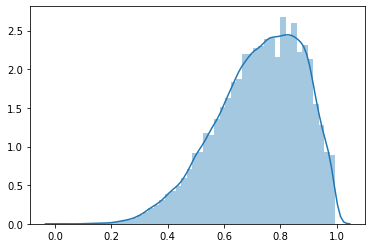

In [39]:
sns.distplot(values)
print('% within-cluster similarity over 0.6: ', round(np.sum(values>=0.6)/values.shape[0]*100,2), '%')

In [40]:
for p in avg_similarity:
    if avg_similarity[p] <= 0.4:
        print(p, ': ', cluster[p], '\n')

crackers chocolate grahams :  ['keebler grahams crackers elf chocolate 1oz', 'chocolate crackers grahams'] 

mix cheese double :  ['sunshine cheezit crackers snack mix double cheese 3.5oz', 'double cheese snack mix'] 

sugar roll :  ['keebler cones honey roll sugar 800ct', 'sugar free milas sourdough roll', 'sugar cookie mix roll cut'] 

indian savory :  ['kashi crunchy bars indian inspired savory 1.05oz', 'indian style savory sides sauced garbanzos with peppers onions curry'] 

cereal spelt :  ['kashi organic cereal cranberry spelt and flax granola 11oz', 'bobs red mill rolled spelt hot cereal whole grain'] 

fudge pumpkin :  ['keebler fudge shoppe cookies pumpkin spice 11.5oz', 'kara chocolates fudge pumpkin spice', 'pumpkin fudge'] 

fruit pieces juice :  ['kelloggs other licensed fruit pieces juicy juice 0.8oz', 'real fruit juice pieces coveredin dark chocolate'] 

apple cinnamon cereal bar :  ['kelloggs cereal breakfast bar apple cinnamon 1.27oz', 'apple cinnamon fruit grain cerea

cinnamon cake pecan coffee :  ['markets of meijer fresh coffee cake ring cinnamon pecan', 'cinnamon pecan coffee cake'] 

ground organic paprika :  ['organic ground paprika', 'paprika ground organic spices'] 

cheese goat peppadew :  ['joan of arc fresh peppadew goat cheese', 'goat cheese peppadew'] 

cheese wasabi :  ['yanceys fancy pasteurized process aged cheddar cheese hot wasabi horshradish', 'wasabi cheese', 'soft spreadable cheese wasabi cheddar bold'] 

pepper 3 :  ['3 chile pepper gouda', 'ultimate firehouse chefcreated cheeses blend grand cru 3 chile pepper gouda smoked fontina'] 

rosemary date :  ['meijer cracker crisps rosemary date', 'date rosemary free range chicken jerky'] 

wild grill salmon :  ['zesty grill wild alaska marinated sockeye salmon', 'wild salmon seasoned grill'] 

kale meijer :  ['markets of meijer kale and parmesan cheese dip', 'meijer chopped kale'] 

bread seed rye :  ['mestemacher suflower seed bread with whole rye kernels', 'sprouted rye seed bread']

cheese spinach artichoke appetizers :  ['great american appetizers inc spinach cheese artichoke dip', 'bags of gold cheese spinach artichoke appetizers'] 

bread kit :  ['gyros kit with pocket pita bread', 'bread kit'] 

herring kippered :  ['western family kippered snacks kippered herring fillets', 'herring smoked kippered'] 

pasta di farro :  ['pastificio di bari taralloro manicotti al farro pasta', 'pasta integrale di farro'] 

mango thins :  ['farmers crate sweet crispy baked mango thins', 'mango thins baked'] 

mix syrup :  ['mama sitas seaweed gel mix syrup', 'mix fruitin light syrup'] 

indian punjab :  ['punjab red tandoori medium heat indian seasoning', 'indian punjab potatoes'] 

rosemary rosemary :  ['vanini dark chocolate 62% cocoa with rosemary rosemary', 'rosemary almonds rosemary'] 

pumpkin cocoa :  ['stephens gourmet hot cocoa pumpkin', 'cocoa pumpkin seed muesli square'] 

sugar our :  ['our signature family recipe featuring butterroasted pecans and brown sugar', 'ou

turkey y big :  ['big y turkey bacon wood smoked', 'big y classic italian style spaghetti with turkey meatballs'] 

vanilla bean cheesecake :  ['daystar desserts cheesecake vanilla bean', 'vanilla bean cheesecake'] 

sugar n spice :  ['robert rothschild farm gingerbread dip sugar n spice', 'sugar n spice paprika'] 

chocolate natural brownie :  ['frankly natural bakers brownie chunky chocolate', 'chocolate brownie all natural cookies'] 

cheese jalapeno taco :  ['shredded cheddar monterey jack cheese with jalapeno peppers taco blend', 'jalapeno cheese taco'] 

cake rum :  ['the original yahoo baking co cordial cake caribbean rum', 'rum cake', 'rum cake without icing'] 

cake nut cranberry :  ['best brand corp loaf cake cranberry nut', 'cranberry nut sliced loaf cake'] 

fruit orange food :  ['food club fruit snacks strawberry orange blue raspberry grape cherry apple', 'mountain high food co real fruit orange marmalade'] 

cheese cheese taco :  ['fancy shredded 2 cheese mexican taco che


tea elixir :  ['tea elixir', 'organic matcha latte plant powered energizing elixir with whole leaf green tea coconutmilk'] 

style meat loaf :  ['home style meat loaf', 'meat loaf puerto rican style'] 

mushroom burger :  ['vegan stuffed mushroom burger', 'morning star farms veggie burgers mushroom lovers burger made with portabella and button mushrooms'] 

fish tofu :  ['frozen fish tofu', 'fish tofu and vegetables tempura'] 

tip tri :  ['bbq beef tri tip', 'santa maria tri tip seasoning'] 

milk nog :  ['mimis milk nog', 'fresh holiday nog 2% milk fat'] 

wheat uncooked :  ['uncooked whole wheat tortillas', 'wheat kamut khorasan uncooked'] 

orange gel :  ['gel cups orange', 'orange sparkling gel'] 

apple dippers :  ['caramel apple dippers', 'apple dippers with caramel cheesecake cinnamon creamy'] 

candy tree :  ['tree lollipops candy', 'bakery crafts christmas tree cupcake decoration kit with candy balls'] 

ground chia :  ['ground chia seed', 'chia black ground'] 

candy footba

frozen rhubarb :  ['fresh frozen sliced rhubarb', 'rhubarb frozen ns as to sweetened or unsweetened sweetened ns as to type of sweetener', 'rhubarb frozen uncooked'] 

cheese cheese garlic garlic and :  ['roasted garlic and asiago cheese flavored broccoli crisps roasted garlic and asiago cheese', 'garlic and parmesan cheese tender homestyle breadsticks garlic and parmesan cheese'] 

pepper pepper 3 :  ['3 pepper natural cheese 3 pepper', 'medium 3 pepper a blend of monterey jack cheese with jalapeno habanero peppers and cheddar cheese with chipotle peppers medium 3 pepper'] 

sunflower sunflower chia chia :  ['ezekiel organic chia sunflower seed bread pain organic chia sunflower seed ezekiel', 'chia sunflower seed crispbread chia sunflower seed'] 

chocolate milk champagne :  ['milk chocolate champagne bottle', 'champagne strawberries marshmallow coveredin milk chocolate'] 

cheese cheese onion onion :  ['cheese onion pierogi cheese onion', 'onion with asiago cheese seasoned butter oni

## Between-cluster Similarity

We calculate the similarity between cluster names.

In [41]:
arr = np.arange(0, 1.1, 0.1)
similarity_distribution = {round(key,1): 0 for key in arr} 
similarity_distribution

start_time = time.time()

keys = list(cluster.keys())

sample_keys = random.sample(keys, 3000)
n = len(sample_keys)
for i in range(n-1):
    if i% 100 == 0:
        print("Progress {p:.2f}%".format(p = 100*i/n))
    base = keys[i]
    for item in sample_keys[i+1:]:
        if abs(len(base) - len(item)) <= 10:
            dist = math.floor(SequenceMatcher(None, base, item).ratio()*10)/10
            similarity_distribution[dist] +=1
similarity_distribution

Progress 0.00%
Progress 3.33%
Progress 6.67%
Progress 10.00%
Progress 13.33%
Progress 16.67%
Progress 20.00%
Progress 23.33%
Progress 26.67%
Progress 30.00%
Progress 33.33%
Progress 36.67%
Progress 40.00%
Progress 43.33%
Progress 46.67%
Progress 50.00%
Progress 53.33%
Progress 56.67%
Progress 60.00%
Progress 63.33%
Progress 66.67%
Progress 70.00%
Progress 73.33%
Progress 76.67%
Progress 80.00%
Progress 83.33%
Progress 86.67%
Progress 90.00%
Progress 93.33%
Progress 96.67%


{0.0: 80575,
 0.1: 620026,
 0.2: 1257325,
 0.3: 711359,
 0.4: 145563,
 0.5: 23139,
 0.6: 3871,
 0.7: 595,
 0.8: 136,
 0.9: 7,
 1.0: 34}

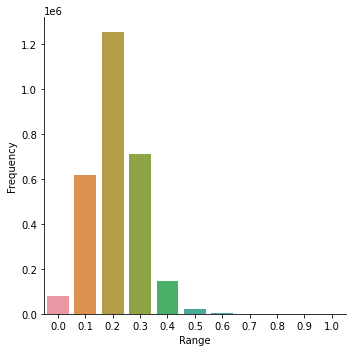

In [42]:
sd = pd.DataFrame(similarity_distribution.items(), columns=['Range', 'Frequency'])
sns.catplot(x="Range", y="Frequency", kind="bar", data=sd)

In [43]:
a = list(similarity_distribution.values())
np.sum(a[0:4])/np.sum(a)

0.9390194995479538

## Master Catalog Generation
1. For the cluster with only one item, add that item into the catalog
2. For the cluster with more than one items, verify the items cluster by cluster
- Split the product name into "size" + "other part".
    - e.g kelloggs cereal breakfast bar apple cinnamon 1.27oz $\rightarrow$ 1.27oz + kelloggs cereal breakfast bar apple cinnamon


 - If all products in this cluster have different size, it means they are different product at UPC level. So add them into the master catalog.
    - e.g kelloggs poptarts beer : \[kelloggs poptarts root beer 3.53oz,  kelloggs poptarts root beer 28.2oz, kelloggs poptarts root beer 14.1oz\]


 - If some of the products has the same size, we compare the similarity of the remaining part except the size tokens.
    - e.g "red gold 46oz no salt added tomato juice", "red gold tomato juice no salt added 46oz"
    - compare the part without size tokens: "red gold no salt added tomato juice" vs. "red gold tomato juice no salt added". Compare the string in original order and in the token id ascending order.
    - If similarity >= 0.95, regard them as the duplicate name, and add the name with higher token frequency into the master catalog.

In [44]:
def name_break_down(name):
    sizes = []
    others = []
    ts = name.split()
    for token in ts:
        idx = tokenlexicon.tokentoidx[token]
        if tokenlexicon.idxtofield[idx] == 'size':
            sizes.append(idx)
        else:
            others.append(idx)
    sizes.sort()
    return ' '.join([tokenlexicon.idxtotoken[n] for n in sizes]), ' '.join([tokenlexicon.idxtotoken[n] for n in others]), ' '.join([tokenlexicon.idxtotoken[n] for n in sorted(others)])

name_break_down('kelloggs cereal breakfast bar apple cinnamon 1.27oz ')

('1.27oz',
 'kelloggs cereal breakfast bar apple cinnamon',
 'kelloggs apple cinnamon cereal breakfast bar')

In [45]:
def dplicate_extract(p):
    num_item = len(cluster[p])
    if num_item == 1:
        master_catalog.append(cluster[p][0])
    else:
        name_store = {}
        for name in cluster[p]:
            size_key, _, _ = name_break_down(name)
            if size_key not in name_store:
                name_store[size_key] = [name]
            else:
                name_store[size_key].append(name)
        if len(name_store) == num_item: # no duplicated size:
            for name in cluster[p]:
                master_catalog.append(name)
        else:
            for size_key in name_store:
                if len(name_store[size_key]) == 1:
                    master_catalog.append(name_store[size_key][0])
                else:
                    potential_duplicates.append(name_store[size_key])

In [46]:
master_catalog = []
potential_duplicates = []
for p in cluster:
    dplicate_extract(p)

In [47]:
print('# of items in master catalog:', len(master_catalog))
print('# of potential duplicated groups:', len(potential_duplicates))

# of items in master catalog: 124005
# of potential duplicated groups: 46847


In [48]:
potential_duplicates

[['tutturosso green 14.5oz nsa italian diced tomatoes',
  'tutturosso green 14.5oz nsa diced tomatoes'],
 ['tutturosso green 14.5oz italian diced tomatoes',
  'tutturosso green 14.5oz italian stewed tomatoes'],
 ['honeysuckle white fresh 97% ground white turkey',
  'honeysuckle white 97% ground white turkey'],
 ['honeysuckle whtie 85% ground turkey',
  'honeysuckle white 85% ground turkey',
  'honeysuckle white fresh ground turkey 85%'],
 ['kelloggs poptarts frosted strawberry 14.7oz',
  'kelloggs poptarts strawberry 14.7oz'],
 ['keebler oatmeal cookies iced 13.7oz',
  'keebler oatmeal cookies original 13.7oz'],
 ['keebler iced animal cookies frosted 13oz',
  'keebler iced animal crackers 13oz'],
 ['keebler fudge shoppe cookies chocolate vanilla creme 13.6oz',
  'keebler fudge shoppe cookies vanilla creme 13.6oz'],
 ['keebler club crackers minis original 11oz',
  'keebler club crackers snack sticks original 11oz'],
 ['keebler fudge shoppe cookies fudge stripes 11.5oz',
  'keebler fudge

In [49]:
highly_potential_duplicates = []
not_duplicates = []
threshold = 0.95
for d in potential_duplicates:
    if len(d) == 2:
        name1, name2 = d
        _, other_part_origin1, other_part_sort1 = name_break_down(name1)
        _, other_part_origin2, other_part_sort2 = name_break_down(name2)
        if SequenceMatcher(None, other_part_origin1, other_part_origin2).ratio() >= threshold or SequenceMatcher(None, other_part_sort1, other_part_sort2).ratio() >= threshold:
            highly_potential_duplicates.append([name1, name2])
        else:
            not_duplicates.append(name1)
            not_duplicates.append(name2)
    else:
        other_part_origin_store = []
        other_part_sort_store = []
        temp_store = set()
        for name in d:
            _, other_part_origin, other_part_sort = name_break_down(name)
            other_part_origin_store.append(other_part_origin)
            other_part_sort_store.append(other_part_sort)
        for i in range(len(other_part_origin_store)):
            count = 0
            for j in range(len(other_part_origin_store)):
                if i == j:
                    pass
                else:
                    similarity1 = SequenceMatcher(None, other_part_origin_store[i], other_part_origin_store[j]).ratio()
                    similarity2 = SequenceMatcher(None, other_part_sort_store[i], other_part_sort_store[j]).ratio()
                    if similarity1 >= threshold or similarity2 >= threshold:
                        temp_store.add(d[i])
                        break
                    else:
                        count += 1
            if count == len(other_part_origin_store) - 1:
                not_duplicates.append(d[i])
        if len(temp_store) > 1:
            highly_potential_duplicates.append(list(temp_store))

In [50]:
print('# of potential duplicated groups removed:', len(potential_duplicates) - len(highly_potential_duplicates))
print('# of items added to master catalog: ', len(not_duplicates))
print('# of highly potential duplicated groups: ', len(highly_potential_duplicates))

# of potential duplicated groups removed: 38558
# of items added to master catalog:  94361
# of highly potential duplicated groups:  8289


In [51]:
highly_potential_duplicates

[['honeysuckle white 85% ground turkey',
  'honeysuckle whtie 85% ground turkey'],
 ['red gold 14.5oz whole peeled tomatoes',
  'red gold whole peeled tomatoes 14.5oz'],
 ['red gold 28oz diced tomatoes', 'red gold diced tomatoes 28oz'],
 ['red gold 28oz italian diced tomatoes',
  'red gold italian diced tomatoes 28oz'],
 ['wheat crackers saltines',
  'wheat saltines crackers',
  'saltines wheat crackers'],
 ['red gold 28oz petite diced tomatoes',
  'red gold petite diced tomatoes 28oz'],
 ['red gold 29oz tomato puree 1.045', 'red gold tomato puree 1.045 29oz'],
 ['red gold 29oz tomato sauce', 'red gold tomato sauce 29oz'],
 ['red gold 14.5oz whole peeled tomatoes no salt added',
  'red gold whole peeled tomatoes no salt added 14.5oz'],
 ['red gold 14.5oz stewed tomatoes', 'red gold stewed tomatoes 14.5oz'],
 ['red gold 14.5oz no salt added diced tomatoes',
  'red gold diced tomatoes no salt added 14.5oz'],
 ['red gold chili ready diced tomatoes 14.5oz',
  'red gold 14.5oz diced chili r

In [52]:
retain_one = []
for g in highly_potential_duplicates:
    total_freq = []
    for name in g:
        tokens = name.split()
        freq = [tokenlexicon.idxtofrequency[tokenlexicon.tokentoidx[t]] for t in tokens]
        total_freq.append(np.sum(freq))
    select = np.argmax(total_freq)
    retain_one.append(g[select])

In [57]:
final_catalog = master_catalog+not_duplicates+retain_one

In [59]:
len(final_catalog)

226655

In [60]:
catalog_df = pd.DataFrame({'item_name':final_catalog})

In [62]:
catalog_df.to_csv('master_catalog.csv', index=False)